### 原始的全连接网络

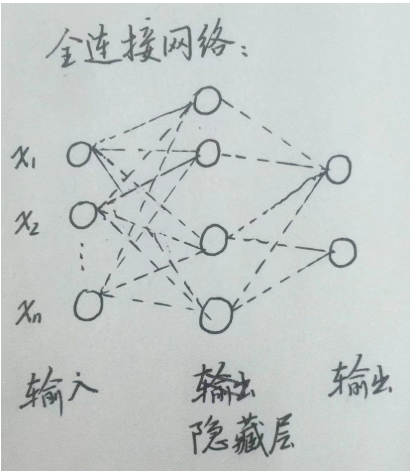

### RNN网络
1. 每个时间步的隐藏状态
在 RNN 中，每个输入（如 x₁、x₂、xₙ）都会对应生成一个隐藏状态（a₁、a₂、aₙ）。
a₁：是输入 x₁经过 RNN 计算后得到的隐藏状态，代表 x₁及初始信息（a₀）的综合特征。
a₂：是输入 x₂结合上一时刻隐藏状态 a₁计算后的结果，包含 x₁、x₂的序列信息。
2. 最后一个时间步的输出
aₙ是整个序列处理后的最后隐藏状态。
若模型用于单步预测（如股价、气温预测），通常取最后一个隐藏状态 aₙ进一步计算输出（如通过全连接层得到最终预测值 yₙ）。
## !!!RNN整个更新的是一套参数！！！！共享一套参数

![示例图片](Note_imags\0b0cc13520b0e96bb26a73671401e5e.png)

## 梯度裁剪

防止梯度爆炸的常用技术，其核心思想是通过限制梯度的大小来稳定训练过程
- 裁剪逻辑：
在梯度计算后，若梯度的范数（如 L2 范数）超过设定阈值，则按比例缩放梯度，使其不超过该阈值

（1）全局裁剪
直接设定梯度的最大值，超过部分截断：
```python 
if grad > max_grad_value:
     grad = max_grad_value
```

（2）范数裁剪
计算梯度的范数（如 L2 范数），若超过阈值则按比例缩放：
```python
# torch.norm 函数用于计算张量的范数
norm = torch.norm(grad)
if norm > max_norm:
    grad = grad * (max_norm / norm)
```

# Goodenote笔记


<div style="display: flex; gap: 10px;"> <!-- gap 可选，用于设置图片间距 -->
  <img src="Note_imags\20cb3fab90662d544749a844b693811.jpg" width="50%">
  <img src="Note_imags\75205aceacdb2f2d3013986ef7ec5fb.jpg" width="50%">
</div>
<div style="display: flex; gap: 10px;"> <!-- gap 可选，用于设置图片间距 -->
  <img src="Note_imags\972813a89c2405c9b68ea790980e7b3.jpg" width="50%">
  <img src="Note_imags\ac1ec5c09b5802d3b1df3d86215b931.jpg" width="50%">
</div>

![shilie](Note_imags\9cbe42bed551dbd2320486d968a99bf.jpg)

## ！！！RNN模型的输入数据格式

Input_shape=(samples,time_steps,features)
- samples:样本数量(模型根据输入数据自动计算)，可以省略不写
- time_steps:序列的长度,即用多少个连续样本预测一个输出
- features:样本的特征维数([0,0,1]对应为3)


>假设股票数据样本有100个,每次用8条数据预测第9条,股票数据为单维度数值,要求输入数据的shape为(100,8,1)


使用tensorflow的架构

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

# 定义时间步长
time_step = 10
# 创建了一个 Sequential 模型的实例 model，后续我们将向这个模型中添加不同的层。
# 创建顺序模型
model = Sequential()
# units=5,RNN 层有 5 个隐藏单元，输出一个长度为 5 的向量作为该层的输出
# 添加 SimpleRNN 层
model.add(SimpleRNN(units=5, input_shape=(time_step, 1), activation='relu'))

# 添加全连接层，units=1,该层会输出一个标量值
model.add(Dense(units=1, activation='relu'))

# 打印模型结构
model.summary()

##### 使用pytorch的架构
假设我们用 RNN 模型预测未来 1 天的股价，输入数据是过去 5 天的股价序列（如[P1, P2, P3, P4, P5]），则：
每个时间步的处理：
RNN 会逐天处理输入数据（从 P1 到 P5），每个时间步的隐藏状态会累积历史信息。
例如：处理 P3 时，隐藏状态包含 P1-P3 的趋势；处理 P5 时，隐藏状态包含 P1-P5 的完整趋势。
最后一个时间步的输出：
当处理完 P5 后，RNN 的最后一个时间步输出（out[:, -1, :]）已经融合了所有历史数据的信息。
这个输出会被全连接层映射为对第 6 天股价的预测值（假设模型用于单步预测）。
为什么选择最后一个时间步？
单步预测需求：
股票预测常关注未来某一时刻的价格（如次日开盘价），而非每个时间点的连续预测。
最后一个时间步的输出直接对应预测目标的时间点。
--- ---
信息浓缩：
RNN 通过隐藏状态逐步提炼历史数据的关键特征（如趋势、波动），最后一个时间步的输出是这些特征的综合体现。
例如：若过去 5 天股价持续上涨，最后一个时间步的输出会隐含 “上涨趋势” 的信息。
示例：模型输入与输出
输入（时间步）	处理逻辑	输出（预测结果）
第 1 天股价（P1）	初始化隐藏状态	无（仅更新状态）
第 2 天股价（P2）	结合 P1 和 P2 更新状态	无
...	...	...
第 5 天股价（P5）	结合 P1-P5 更新状态	最后时间步输出 → 第 6 天股价预测值
总结
在股票预测中，取最后一个时间步的输出是为了直接获取融合了所有历史信息的预测结果，适用于单步预测任务。如果需要预测多步（如未来 5 天股价），则需调整模型结构（如使用序列到序列模型或自回归预测）。


In [ ]:
import torch
import torch.nn as nn

class SimpleRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size):
       
        super(SimpleRNNModel, self).__init__()
        # 定义一个简单的 RNN 层，input_size 是每个时间步的输入特征维度，hidden_size 是隐藏层神经元数量
        # batch_first=True 表示输入数据的第一个维度是批次大小
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        # 定义一个全连接层，将 RNN 层的输出映射到最终的输出维度（这里是 1）
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # 前向传播过程，将输入 x 传入 RNN 层
        # out 是 RNN 层在每个时间步的输出，_ 是最后一个时间步的隐藏状态（这里暂时不使用）
        out, _ = self.rnn(x)
        # 取每个样本在最后一个时间步的输出
        out = out[:, -1, :]
        # 将最后一个时间步的输出传入全连接层，得到最终的输出
        out = self.fc(out)
        return out


In [ ]:
#### RNN 会依次处理每个时间步的输入：
for t in range(seq_length):
    # 当前时间步的输入：[batch_size, input_size]
    x_t = x[:, t, :]
    
    # 计算当前隐藏状态：
    # h_t = tanh(W_ih * x_t + W_hh * h_{t-1} + b_ih + b_hh)
    h_t = torch.tanh(W_ih @ x_t + W_hh @ h_prev + b_ih + b_hh)
    
    # 保存当前时间步的输出
    out_t = h_t
    h_prev = h_t 

### 实战一：股价预测
#### 任务:基于zgpa_train.csv数据,建立RNN模型,预测股价:
1. 完成数据预处理,将序列数据转化为可用子RNN输入的数据
2. 对新数据zgpa_test.csv进行预测,可视化结果
3. 存储预测结果,并观察局部预测结果
- 模型结构:单层RNN 输出有5个神经元
- 每次使用前8个数据预测第9个数据
<img src="Note_imags\image.png" width="100%">

#### 核心代码

In [1]:
#提取序列数据

def extract_data(data, slide):
    X = []
    y = []
    for i in range(len(data) - slide):
        x.append([a for a in data[i:i+slide]])
        y.append(data[i+slide])
    x = np.array(x)
    x = x.reshape(x.shape[0],x.shape[1],1)
    return X,Y

In [3]:
# 建立普通RNN模型:

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
model = Sequential()
#增加一个RNN层
model.add(SimpleRNN(units=5,
input_shape = (X.shape[1],X.shape[2]),
activation= relu ))
#增加输出层
model.add(Dense(units=1,activation='linear'))
model.compile(optimizer='adam' ,
loss='mean_squared_error')

ModuleNotFoundError: No module named 'tensorflow'

<img src="Note_imags\image1.png" width="100%">

In [ ]:
# 文本加载
raw_data = open('flare').read()
# 移除换行符
data = raw_data.replace('\n','').replace('\r','')
# 字符字典的建立
# 字符去重
letters = list(set(data))
# 0:a,1:b,2:c----------
# 建立数字到字符的索引
int_to_char = {a:b for a,b in enumerate(letters)}
# 建立字符到数字的索引
int_to_char = {b:a for a,b in enumerate(letters)}